# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import json
import numpy as np
import pandas as pd
import pprint
import time
import yaml

from benchmarks.generator import get_revenue_behaviour
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 30


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
AVLO                    5
IRYO                   11
AVE                     8
OUIGO                   6
Total                  30


Services:  30


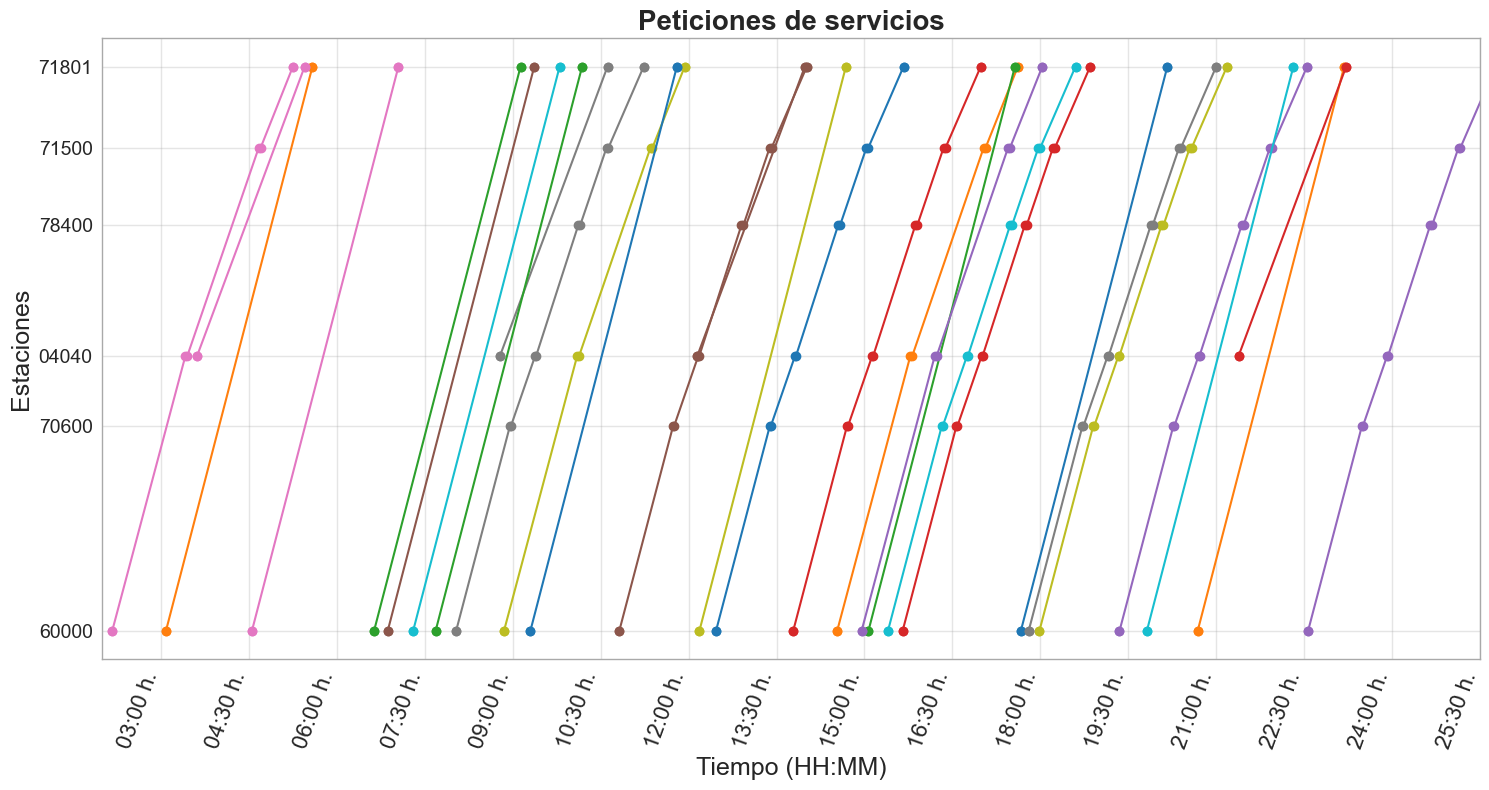

In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour(requested_schedule)
lines = supply.lines
line = infer_line_stations(lines)

plotter = TrainSchedulePlotter(requested_schedule, line)
plotter.plot(main_title="Peticiones de servicios")

In [6]:
#pr = profile.Profile()
#pr.enable()

def run_gsa(chaotic_constant: bool=False,
            runs: int=10,
            population_size: int=20,
            iters: int=50
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in range(1, runs + 1):
        print(f"Run {r}")
        sm = RevenueMaximization(requested_schedule=requested_schedule,
                                 revenue_behaviour=revenue_behaviour,
                                 line=line,
                                 safe_headway=10)
    
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
    
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iters,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=True,
                                             initial_population=sm.get_initial_population(population),
                                             verbose=verbosity,
                                             save_population=True)
    
        training_history.insert(0, "Run", r)
        training_history['Discrete'] = [sm.get_heuristic_schedule(Solution(real=r, discrete=np.array([]))) for r in training_history['Real']]
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        gsa_algo.population_history.insert(0, "Run", r)
        global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
        
    return global_train_hist, global_population_hist, runs_best_solution_history
        
#pr.disable()
#pr.dump_stats('profile.pstat')

In [7]:
runs = 5
population = 20
iters = 50
chaotic = True
verbosity = False

df_train_global, df_population, runs_best_solution_history = run_gsa(chaotic_constant=chaotic,
                                                                     runs=runs,
                                                                     population_size=population,
                                                                     iters=iters)

Run 1
Run 2
Run 3
Run 4
Run 5


In [8]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [9]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

run_grouped_df = df_train_global.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),AVE,AVLO,IRYO,OUIGO
0,1,4429.551748,11.861061,18,32.0,173.0,60.0 %,72.73 %,37.5 %,66.67 %
3,4,4355.418431,11.733790,18,34.0,206.0,60.0 %,72.73 %,37.5 %,66.67 %
2,3,4341.914604,11.824264,18,26.0,200.0,60.0 %,72.73 %,37.5 %,66.67 %
4,5,4161.295718,11.720412,17,27.0,219.0,60.0 %,63.64 %,37.5 %,66.67 %
1,2,4136.559566,11.767060,17,20.0,218.0,60.0 %,63.64 %,37.5 %,66.67 %


In [10]:
# Global status
print("Global GSA status:")

# Execution time (mean and std.)
run_times = run_grouped_df['ExecutionTime'].last()
print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')

# Revenue (mean and std.)
run_revenues = run_grouped_df['Fitness'].last()
print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')

# Scheduled trains (mean and std.)
run_trains = run_grouped_df['Discrete'].last().apply(sum)
print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')

runs_best_solution_history = dict(sorted(runs_best_solution_history.items(),
                                         key=lambda x: x[1][1]))

q2_solution_index = np.floor(runs // 2).astype(int)
gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]

print(f"\tMedian solution: Run {gsa_solution[0]}")
max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")

Global GSA status:
	Total execution time: 58.9066 s.
	Execution Time (by run) - Mean: 11.7813 s. - Std: 0.0599 s.
	Revenue - Mean: 4284.948 - Std: 128.8706
	Scheduled Trains - Mean: 18.0 - Std: 1.0
	Median solution: Run 3
	Max Revenue: 7293.0 - WARNING!: Scheduling all services could not be feasible


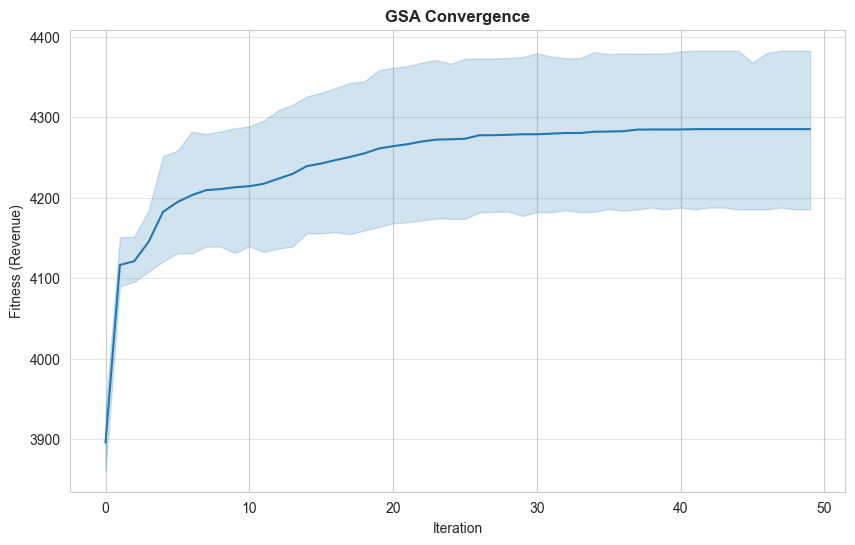

In [11]:
# GSA Convergence plot
sns_line_plot(df=df_train_global,
              x_data="Iteration",
              y_data="Fitness",
              # hue="chaotic_constant",
              title="GSA Convergence",
              x_label="Iteration",
              y_label="Fitness (Revenue)",
              save_path=Path('../figures/gsa_convergence.pdf'))

True
H


/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


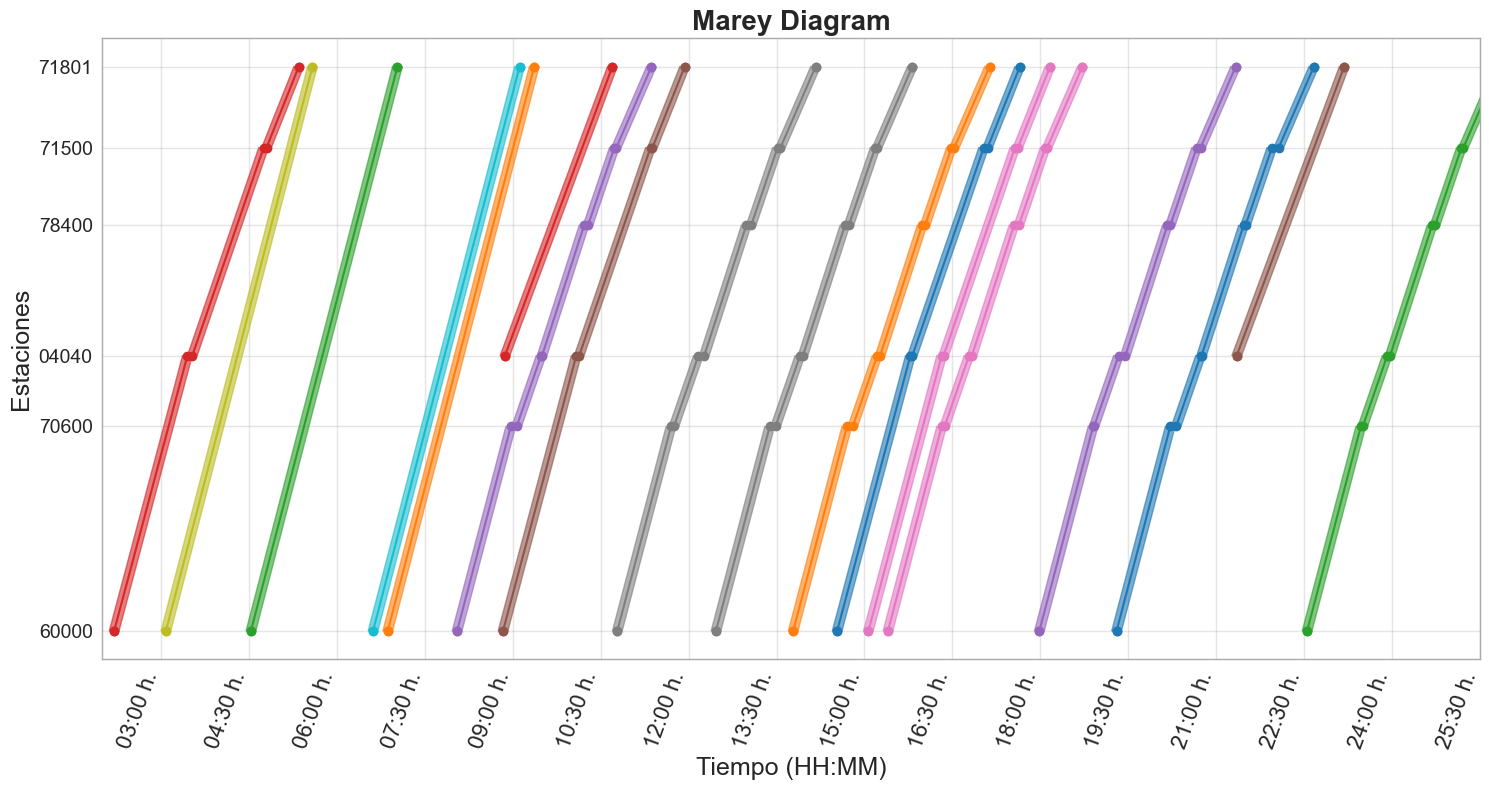

In [12]:
sm.update_schedule(solution=gsa_solution[1][0])

print(sm.is_feasible(timetable=Solution(real=np.array(gsa_solution[1][0].real),
                                        discrete=np.array([])),
                    scheduling=np.array(gsa_solution[1][0].discrete),
                    update_schedule=True))

print("H")
check_conf = (np.array(gsa_solution[1][0].discrete, dtype=np.bool_) * sm.conflict_matrix)[np.array(gsa_solution[1][0].discrete, dtype=np.bool_)]
for r in check_conf:
    if any(r):
        print("Conflict")

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.updated_schedule
filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

plotter = TrainSchedulePlotter(filtered_services, line)
plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [32]:
filtered_services

{'3_2024-06-25-13.47': {'60000': [827, 827],
  '70600': [882, 884],
  '04040': [909, 911],
  '78400': [954, 960],
  '71500': [987, 990],
  '71801': [1026, 1026]},
 '4_2024-06-25-22.34': {'60000': [1353, 1353],
  '70600': [1408, 1413],
  '04040': [1438, 1443],
  '78400': [1486, 1490],
  '71500': [1517, 1519],
  '71801': [1555, 1555]},
 '6_2024-06-25-2.10': {'60000': [130, 130],
  '04040': [205, 212],
  '71500': [285, 289],
  '71801': [322, 322]},
 '7_2024-06-25-8.02': {'60000': [482, 482],
  '70600': [537, 540],
  '04040': [565, 569],
  '78400': [612, 616],
  '71500': [643, 645],
  '71801': [681, 681]},
 '8_2024-06-25-8.51': {'60000': [531, 531],
  '04040': [606, 608],
  '71500': [681, 683],
  '71801': [716, 716]},
 '10_2024-06-25-12.28': {'60000': [748, 748],
  '70600': [803, 808],
  '04040': [833, 834],
  '78400': [877, 883],
  '71500': [910, 913],
  '71801': [949, 949]},
 '12_2024-06-25-6.38': {'60000': [396, 396], '71801': [546, 546]},
 '13_2024-06-25-15.39': {'60000': [939, 939],
 

In [17]:
sm.requested_schedule.keys()

dict_keys(['0_2024-06-25-17.40', '1_2024-06-25-14.32', '2_2024-06-25-15.04', '3_2024-06-25-13.47', '4_2024-06-25-22.34', '5_2024-06-25-12.09', '6_2024-06-25-2.10', '7_2024-06-25-8.02', '8_2024-06-25-8.51', '9_2024-06-25-15.24', '10_2024-06-25-12.28', '11_2024-06-25-3.05', '12_2024-06-25-6.38', '13_2024-06-25-15.39', '14_2024-06-25-19.21', '15_2024-06-25-6.52', '16_2024-06-25-4.33', '17_2024-06-25-8.47', '18_2024-06-25-17.59', '19_2024-06-25-19.49', '20_2024-06-25-9.18', '21_2024-06-25-20.41', '22_2024-06-25-7.41', '23_2024-06-25-21.23', '24_2024-06-25-14.57', '25_2024-06-25-10.49', '26_2024-06-25-3.37', '27_2024-06-25-17.48', '28_2024-06-25-12.11', '29_2024-06-25-7.18'])

In [33]:
sm.updated_schedule

{'0_2024-06-25-17.40': {'60000': [1062, 1062], '71801': [1212, 1212]},
 '1_2024-06-25-14.32': {'60000': [872, 872],
  '04040': [947, 953],
  '71500': [1026, 1031],
  '71801': [1064, 1064]},
 '2_2024-06-25-15.04': {'60000': [900, 900], '71801': [1050, 1050]},
 '3_2024-06-25-13.47': {'60000': [827, 827],
  '70600': [882, 884],
  '04040': [909, 911],
  '78400': [954, 960],
  '71500': [987, 990],
  '71801': [1026, 1026]},
 '4_2024-06-25-22.34': {'60000': [1353, 1353],
  '70600': [1408, 1413],
  '04040': [1438, 1443],
  '78400': [1486, 1490],
  '71500': [1517, 1519],
  '71801': [1555, 1555]},
 '5_2024-06-25-12.09': {'04040': [728, 728], '71801': [838, 838]},
 '6_2024-06-25-2.10': {'60000': [130, 130],
  '04040': [205, 212],
  '71500': [285, 289],
  '71801': [322, 322]},
 '7_2024-06-25-8.02': {'60000': [482, 482],
  '70600': [537, 540],
  '04040': [565, 569],
  '78400': [612, 616],
  '71500': [643, 645],
  '71801': [681, 681]},
 '8_2024-06-25-8.51': {'60000': [531, 531],
  '04040': [606, 608

In [19]:
sm.conflict_matrix

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False],
       [False,  True, False, False, False, False, False, False, False,
         True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False,

In [20]:
sorted_req = dict(sorted(sm.requested_schedule.items(), key=lambda x: list(x[1].values())[0][0]))
sorted_req

{'6_2024-06-25-2.10': {'60000': [130, 130],
  '04040': [205, 207],
  '71500': [280, 282],
  '71801': [315, 315]},
 '11_2024-06-25-3.05': {'60000': [185, 185], '71801': [335, 335]},
 '26_2024-06-25-3.37': {'04040': [217, 217], '71801': [327, 327]},
 '16_2024-06-25-4.33': {'60000': [273, 273], '71801': [423, 423]},
 '12_2024-06-25-6.38': {'60000': [398, 398], '71801': [548, 548]},
 '15_2024-06-25-6.52': {'60000': [412, 412], '71801': [562, 562]},
 '29_2024-06-25-7.18': {'60000': [438, 438], '71801': [588, 588]},
 '22_2024-06-25-7.41': {'60000': [461, 461], '71801': [611, 611]},
 '7_2024-06-25-8.02': {'60000': [482, 482],
  '70600': [537, 538],
  '04040': [563, 564],
  '78400': [607, 609],
  '71500': [636, 638],
  '71801': [674, 674]},
 '17_2024-06-25-8.47': {'04040': [527, 527], '71801': [637, 637]},
 '8_2024-06-25-8.51': {'60000': [531, 531],
  '04040': [606, 608],
  '71500': [681, 683],
  '71801': [716, 716]},
 '20_2024-06-25-9.18': {'60000': [558, 558], '71801': [708, 708]},
 '25_2024

In [21]:
gsa_solution[1][0].real

array([1062,  872,  953, 1031,  900,  827,  884,  911,  960,  990, 1353,
       1413, 1443, 1490, 1519,  728,  130,  212,  289,  482,  540,  569,
        616,  645,  531,  608,  683,  921,  986, 1012, 1059, 1089,  748,
        808,  834,  883,  913,  182,  396,  939,  999, 1025, 1071, 1103,
       1161, 1217, 1249, 1296, 1326,  415,  273,  527, 1077, 1138, 1168,
       1213, 1243, 1187,  559, 1241,  461, 1279,  896,  974, 1053,  647,
        706,  733,  783,  813,  216, 1069, 1126, 1152, 1200, 1232,  731,
        436])

In [22]:
sm.operational_times

{'0_2024-06-25-17.40': [150],
 '1_2024-06-25-14.32': [75, 2, 73, 2, 33],
 '2_2024-06-25-15.04': [150],
 '3_2024-06-25-13.47': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '4_2024-06-25-22.34': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '5_2024-06-25-12.09': [110],
 '6_2024-06-25-2.10': [75, 2, 73, 2, 33],
 '7_2024-06-25-8.02': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '8_2024-06-25-8.51': [75, 2, 73, 2, 33],
 '9_2024-06-25-15.24': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '10_2024-06-25-12.28': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '11_2024-06-25-3.05': [150],
 '12_2024-06-25-6.38': [150],
 '13_2024-06-25-15.39': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '14_2024-06-25-19.21': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '15_2024-06-25-6.52': [150],
 '16_2024-06-25-4.33': [150],
 '17_2024-06-25-8.47': [110],
 '18_2024-06-25-17.59': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '19_2024-06-25-19.49': [150],
 '20_2024-06-25-9.18': [150],
 '21_2024-06-25-20.41': [150],
 '22_2024-06-25-7.41': [150],
 '23_2024-06-25-21.23': [110],
 '24_2024-06-25-14.57

In [23]:
sm.updated_schedule

{'0_2024-06-25-17.40': {'60000': [1062, 1062], '71801': [1212, 1212]},
 '1_2024-06-25-14.32': {'60000': [872, 872],
  '04040': [947, 953],
  '71500': [1026, 1031],
  '71801': [1064, 1064]},
 '2_2024-06-25-15.04': {'60000': [900, 900], '71801': [1050, 1050]},
 '3_2024-06-25-13.47': {'60000': [827, 827],
  '70600': [882, 884],
  '04040': [909, 911],
  '78400': [954, 960],
  '71500': [987, 990],
  '71801': [1026, 1026]},
 '4_2024-06-25-22.34': {'60000': [1353, 1353],
  '70600': [1408, 1413],
  '04040': [1438, 1443],
  '78400': [1486, 1490],
  '71500': [1517, 1519],
  '71801': [1555, 1555]},
 '5_2024-06-25-12.09': {'04040': [728, 728], '71801': [838, 838]},
 '6_2024-06-25-2.10': {'60000': [130, 130],
  '04040': [205, 212],
  '71500': [285, 289],
  '71801': [322, 322]},
 '7_2024-06-25-8.02': {'60000': [482, 482],
  '70600': [537, 540],
  '04040': [565, 569],
  '78400': [612, 616],
  '71500': [643, 645],
  '71801': [681, 681]},
 '8_2024-06-25-8.51': {'60000': [531, 531],
  '04040': [606, 608

In [24]:
sorted_dt = dict(sorted(filtered_services.items(), key=lambda x: tuple(x[1].values())[0][0]))
sorted_dt

{'6_2024-06-25-2.10': {'60000': [130, 130],
  '04040': [205, 212],
  '71500': [285, 289],
  '71801': [322, 322]},
 '26_2024-06-25-3.37': {'04040': [216, 216], '71801': [326, 326]},
 '16_2024-06-25-4.33': {'60000': [273, 273], '71801': [423, 423]},
 '12_2024-06-25-6.38': {'60000': [396, 396], '71801': [546, 546]},
 '15_2024-06-25-6.52': {'60000': [415, 415], '71801': [565, 565]},
 '7_2024-06-25-8.02': {'60000': [482, 482],
  '70600': [537, 540],
  '04040': [565, 569],
  '78400': [612, 616],
  '71500': [643, 645],
  '71801': [681, 681]},
 '17_2024-06-25-8.47': {'04040': [527, 527], '71801': [637, 637]},
 '8_2024-06-25-8.51': {'60000': [531, 531],
  '04040': [606, 608],
  '71500': [681, 683],
  '71801': [716, 716]},
 '25_2024-06-25-10.49': {'60000': [647, 647],
  '70600': [702, 706],
  '04040': [731, 733],
  '78400': [776, 783],
  '71500': [810, 813],
  '71801': [849, 849]},
 '10_2024-06-25-12.28': {'60000': [748, 748],
  '70600': [803, 808],
  '04040': [833, 834],
  '78400': [877, 883],


In [25]:
sm.requested_schedule.keys()

dict_keys(['0_2024-06-25-17.40', '1_2024-06-25-14.32', '2_2024-06-25-15.04', '3_2024-06-25-13.47', '4_2024-06-25-22.34', '5_2024-06-25-12.09', '6_2024-06-25-2.10', '7_2024-06-25-8.02', '8_2024-06-25-8.51', '9_2024-06-25-15.24', '10_2024-06-25-12.28', '11_2024-06-25-3.05', '12_2024-06-25-6.38', '13_2024-06-25-15.39', '14_2024-06-25-19.21', '15_2024-06-25-6.52', '16_2024-06-25-4.33', '17_2024-06-25-8.47', '18_2024-06-25-17.59', '19_2024-06-25-19.49', '20_2024-06-25-9.18', '21_2024-06-25-20.41', '22_2024-06-25-7.41', '23_2024-06-25-21.23', '24_2024-06-25-14.57', '25_2024-06-25-10.49', '26_2024-06-25-3.37', '27_2024-06-25-17.48', '28_2024-06-25-12.11', '29_2024-06-25-7.18'])

In [26]:
sm.operational_times

{'0_2024-06-25-17.40': [150],
 '1_2024-06-25-14.32': [75, 2, 73, 2, 33],
 '2_2024-06-25-15.04': [150],
 '3_2024-06-25-13.47': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '4_2024-06-25-22.34': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '5_2024-06-25-12.09': [110],
 '6_2024-06-25-2.10': [75, 2, 73, 2, 33],
 '7_2024-06-25-8.02': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '8_2024-06-25-8.51': [75, 2, 73, 2, 33],
 '9_2024-06-25-15.24': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '10_2024-06-25-12.28': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '11_2024-06-25-3.05': [150],
 '12_2024-06-25-6.38': [150],
 '13_2024-06-25-15.39': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '14_2024-06-25-19.21': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '15_2024-06-25-6.52': [150],
 '16_2024-06-25-4.33': [150],
 '17_2024-06-25-8.47': [110],
 '18_2024-06-25-17.59': [55, 1, 25, 1, 43, 2, 27, 2, 36],
 '19_2024-06-25-19.49': [150],
 '20_2024-06-25-9.18': [150],
 '21_2024-06-25-20.41': [150],
 '22_2024-06-25-7.41': [150],
 '23_2024-06-25-21.23': [110],
 '24_2024-06-25-14.57

In [27]:
problem_request = {k: v for k, v in tuple(sorted_dt.items())[:2]}
problem_request

{'6_2024-06-25-2.10': {'60000': [130, 130],
  '04040': [205, 212],
  '71500': [285, 289],
  '71801': [322, 322]},
 '26_2024-06-25-3.37': {'04040': [216, 216], '71801': [326, 326]}}

In [28]:
problem_revenue = {k: sm.revenue[k] for k in problem_request}
problem_revenue

{'6_2024-06-25-2.10': {'canon': 297.0,
  'k': 3.18,
  'dt_max_penalty': 41.58,
  'tt_max_penalty': 25.74},
 '26_2024-06-25-3.37': {'canon': 148.5,
  'k': 3.27,
  'dt_max_penalty': 20.79,
  'tt_max_penalty': 38.61}}

In [29]:
pm = RevenueMaximization(requested_schedule=problem_request,
                         revenue_behaviour=problem_revenue,
                         line=line,
                         safe_headway=10)

In [30]:
pm.is_feasible(timetable=Solution(real=np.array(pm.requested_times),
                                  discrete=np.array([])),
               scheduling=np.array([1, 1]))

False

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


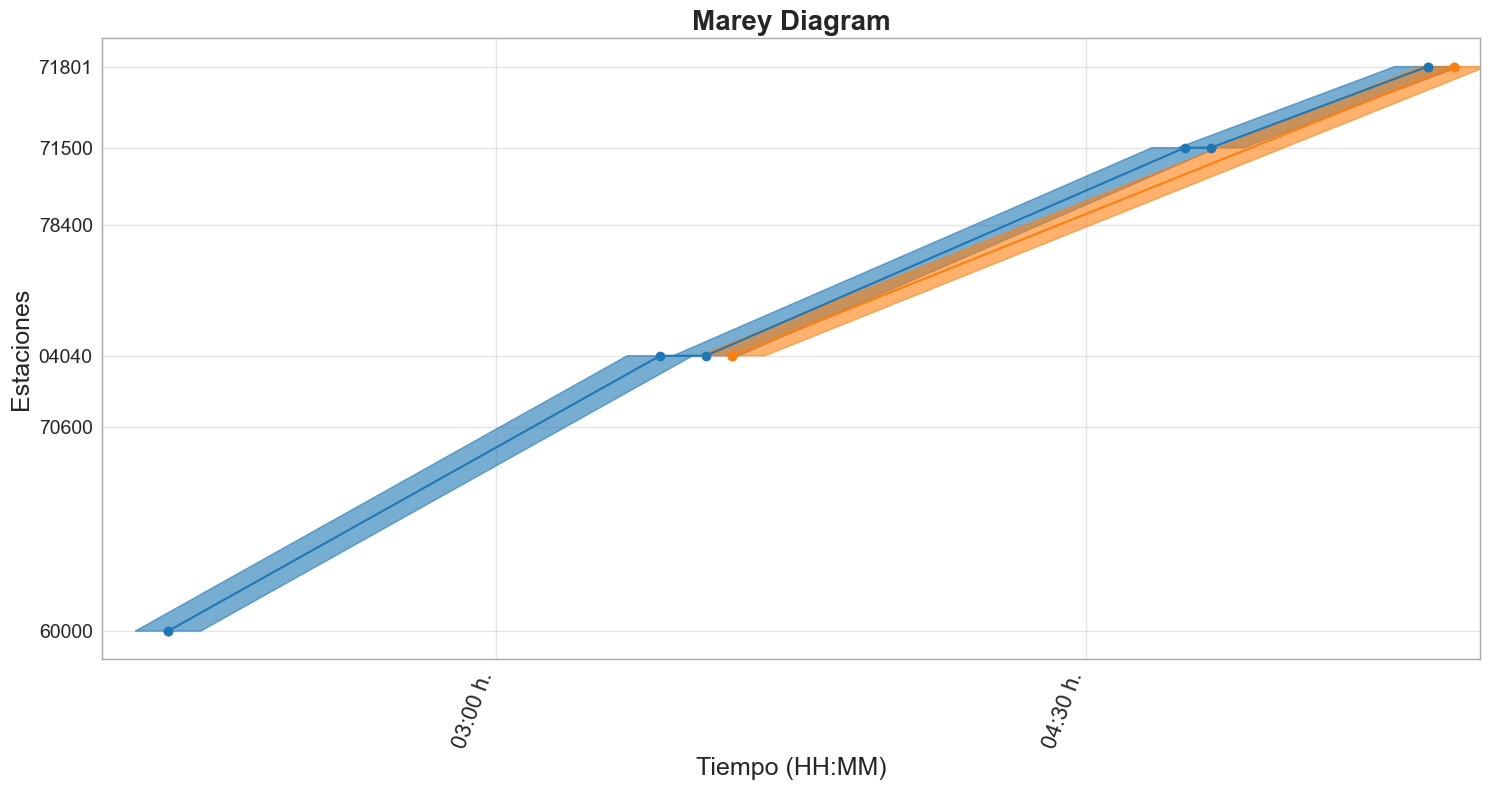

In [31]:
tsplot = TrainSchedulePlotter(problem_request, line)
tsplot.plot(plot_security_gaps=True)

In [16]:
tuple(sorted_dt.values())[-3:]

({'60000': [1244.0, 1244.0], '71801': [1394.0, 1394.0]},
 {'04040': [1282.0, 1282.0], '71801': [1392.0, 1392.0]},
 {'60000': [1354.0, 1354.0],
  '70600': [1409.0, 1410.0],
  '04040': [1435.0, 1441.0],
  '78400': [1484.0, 1488.0],
  '71500': [1515.0, 1519.0],
  '71801': [1555.0, 1555.0]})

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [16]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_file,
                path_config_demand=demand_config_path)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'),
                           save_trace=True,
                           departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_file)

kernel_plotter.plotter_data_analysis()

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 4719
	Status: User bought a service which was not the one with the best utility. - Passengers: 3591
	Status: User bought the ticket with best utility. - Passengers: 897
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4488
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 868 - Percentage: 19.34 %
		Seat: Turista - Passengers: 2661 - Percentage: 59.29 %
		Seat: TuristaPlus - Passengers: 959 - Percentage: 21.37 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4488
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 50
			Seat: Turista - Number of tickets sold: 87
			Seat: TuristaPlus - Number of tickets sold: 14
		Date: 2023-06-12
			Seat: Turista - Number of tickets sold: 72
			Seat: TuristaPlus - Number of

{'Tourist': {'Turista': 1089, 'TuristaPlus': 143, 'Premium': 51}, 'Business': {'Premium': 767, 'TuristaPlus': 298, 'Turista': 1042}, 'Student': {'TuristaPlus': 518, 'Turista': 530, 'Premium': 50}}


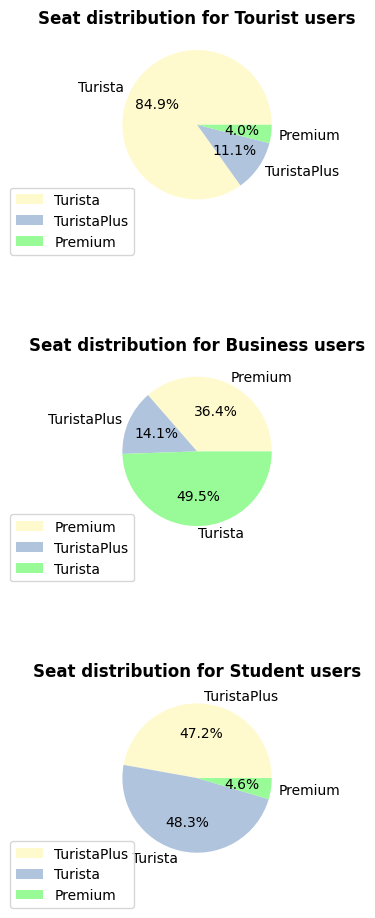

In [17]:
kernel_plotter.plot_users_seat_pie_chart(save_path='../figures/users_seat_pie_chart.pdf')

## Load inference trace

In [18]:
trace_path = Path(f'{robin_save_path}/inference_trace.json')

# Load trace json
with open(trace_path, 'r') as f:
    trace = json.load(f)

In [19]:
# Tickets bought by user pattern

n_pass = {}
for t in trace:
   if trace[t]['user_pattern'] not in n_pass:
       n_pass[trace[t]['user_pattern']] = 1
   else:
       n_pass[trace[t]['user_pattern']] += 1

n_pass

{'Tourist': 1283, 'Business': 2107, 'Student': 1098}

## Load user patterns and variables from demand config file

In [20]:
# Load demand config yaml
with open(demand_config_path, 'r') as f:
    demand_config = yaml.safe_load(f)

In [21]:
user_patterns = []
variables = {}

for user_pattern in demand_config['userPattern']:
    user_patterns.append(user_pattern['name'])
    for variable in user_pattern['variables']:
        if variable['name'] not in variables:
            if variable['type'] == 'fuzzy':
                variables[variable['name']] = variable['sets']
            elif variable['type'] == 'categorical':
                variables[variable['name']] = variable['labels']
        else:
            # Assert set matches
            if variable['type'] == 'fuzzy':
                assert variables[variable['name']] == variable['sets']
            elif variable['type'] == 'categorical':
                assert variables[variable['name']] == variable['labels']
                
print(user_patterns)
pprint.pp(variables)

['Business', 'Student', 'Tourist']
{'origin': ['very_near', 'mid_range', 'far', 'far_away'],
 'destination': ['very_near', 'mid_range', 'far', 'far_away'],
 'departure_time': ['in_time', 'close', 'remote', 'very_remote'],
 'arrival_time': ['in_time', 'close', 'remote', 'very_remote'],
 'price': ['very_cheap', 'cheap', 'medium', 'expensive'],
 'seat': ['Turista', 'TuristaPlus', 'Premium'],
 'tsp': ['AVE', 'AVLO', 'OUIGO', 'IRYO']}


In [43]:
# Create dataframes for each behaviour variable

behaviour_dfs = {}
for variable in variables:
    behaviour_dfs[variable] = pd.DataFrame(columns=user_patterns, index=variables[variable])
    
    for variable_set in variables[variable]:
        behaviour_dfs[variable].loc[variable_set] = [np.zeros(3) for _ in range(len(user_patterns))]
    
    print("Variable: ", variable)
    print(behaviour_dfs[variable])

Variable:  origin
                  Business          Student          Tourist
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
Variable:  destination
                  Business          Student          Tourist
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
Variable:  departure_time
                    Business          Student          Tourist
in_time      [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
close        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
remote       [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
very_remote  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
Variable

In [44]:
def update_behaviour_dfs(behaviour_dfs: Mapping[str, pd.DataFrame],
                         user_pattern: str,
                         rules: List):
    passenger_set = set()
    def recurse_elements(element):
        if isinstance(element, dict):
            if 'variable' in element:
                if element['variable'] in behaviour_dfs:
                    set_name_and_values = element['setname_and_values']
                    set_name = set_name_and_values[0] if type(set_name_and_values) is list else set_name_and_values
                    if set_name in behaviour_dfs[element['variable']].index:
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][0] += element['result']
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][1] += 1
                        if (element['variable'], set_name) not in passenger_set:
                            behaviour_dfs[element['variable']].loc[set_name, user_pattern][2] += 1
                            passenger_set.add((element['variable'], set_name))
            for value in element.values():
                recurse_elements(value)
        elif isinstance(element, list):
            for item in element:
                recurse_elements(item)

    for rule in rules:
        recurse_elements(rule)

    return behaviour_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_behaviour_dfs(behaviour_dfs=behaviour_dfs,
                                         user_pattern=user_pattern,
                                         rules=trace[passenger]['trace_of_each_rule'])
    
for var in behaviour_dfs:
    print(f'Variable: {var}')
    display(behaviour_dfs[var])

Variable: origin


,Business,Student,Tourist
very_near,"[4472.0, 4472.0, 2236.0]","[1006.0, 1006.0, 503.0]","[1105.0, 1105.0, 1105.0]"
mid_range,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
far,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
far_away,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: destination


,Business,Student,Tourist
very_near,"[4472.0, 4472.0, 2236.0]","[1006.0, 1006.0, 503.0]","[1105.0, 1105.0, 1105.0]"
mid_range,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1105.0, 1105.0]"
far,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
far_away,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: departure_time


,Business,Student,Tourist
in_time,"[4472.0, 4472.0, 2236.0]","[419.3149999999999, 503.0, 503.0]","[875.4633333333305, 1105.0, 1105.0]"
close,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[229.53666666666578, 1105.0, 1105.0]"
remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1105.0, 1105.0]"
very_remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: arrival_time


,Business,Student,Tourist
in_time,"[4470.450000000042, 4472.0, 2236.0]","[388.15500000000435, 503.0, 503.0]","[720.1358333333415, 1105.0, 1105.0]"
close,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[384.86416666666366, 1105.0, 1105.0]"
remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1105.0, 1105.0]"
very_remote,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: price


,Business,Student,Tourist
very_cheap,"[0.0, 0.0, 0.0]","[0.0, 466.0, 466.0]","[69.11399999999988, 1034.0, 1034.0]"
cheap,"[0.0, 0.0, 0.0]","[450.64999999999986, 466.0, 466.0]","[963.0439999999973, 1034.0, 1034.0]"
medium,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
expensive,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: seat


,Business,Student,Tourist
Turista,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1099.0, 1099.0, 1099.0]"
TuristaPlus,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
Premium,"[656.0, 656.0, 656.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


Variable: tsp


,Business,Student,Tourist
AVE,"[1050.0, 1050.0, 1050.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
AVLO,"[0.0, 1050.0, 1050.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
OUIGO,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
IRYO,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


In [70]:
# Multicolumn pandas dataframes

for df in behaviour_dfs: 
    values = behaviour_dfs[df].values
    np_vals = np.array([val for row in values for data in row for val in data], dtype=np.float32)
    np_vals = np_vals.reshape(len(behaviour_dfs[df].index), len(behaviour_dfs[df].columns) * len(user_patterns))
    
    midx = pd.MultiIndex.from_product([user_patterns, ['Sum', 'Count', 'Passengers']])
    multicol_df = pd.DataFrame(np_vals, index=behaviour_dfs[df].index, columns=midx)
    multicol_df

Business                    Student                    Tourist  \
               Sum   Count Passengers     Sum   Count Passengers     Sum   
very_near   4472.0  4472.0     2236.0  1006.0  1006.0      503.0  1105.0   
mid_range      0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far            0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far_away       0.0     0.0        0.0     0.0     0.0        0.0     0.0   

                              
            Count Passengers  
very_near  1105.0     1105.0  
mid_range     0.0        0.0  
far           0.0        0.0  
far_away      0.0        0.0

Business                    Student                    Tourist  \
               Sum   Count Passengers     Sum   Count Passengers     Sum   
very_near   4472.0  4472.0     2236.0  1006.0  1006.0      503.0  1105.0   
mid_range      0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far            0.0     0.0        0.0     0.0     0.0        0.0     0.0   
far_away       0.0     0.0        0.0     0.0     0.0        0.0     0.0   

                              
            Count Passengers  
very_near  1105.0     1105.0  
mid_range  1105.0     1105.0  
far           0.0        0.0  
far_away      0.0        0.0

Business                        Student                    \
                 Sum   Count Passengers         Sum  Count Passengers   
in_time       4472.0  4472.0     2236.0  419.315002  503.0      503.0   
close            0.0     0.0        0.0    0.000000    0.0        0.0   
remote           0.0     0.0        0.0    0.000000    0.0        0.0   
very_remote      0.0     0.0        0.0    0.000000    0.0        0.0   

                Tourist                     
                    Sum   Count Passengers  
in_time      875.463318  1105.0     1105.0  
close        229.536667  1105.0     1105.0  
remote         0.000000  1105.0     1105.0  
very_remote    0.000000     0.0        0.0

Business                        Student                    \
                     Sum   Count Passengers         Sum  Count Passengers   
in_time      4470.450195  4472.0     2236.0  388.154999  503.0      503.0   
close           0.000000     0.0        0.0    0.000000    0.0        0.0   
remote          0.000000     0.0        0.0    0.000000    0.0        0.0   
very_remote     0.000000     0.0        0.0    0.000000    0.0        0.0   

                Tourist                     
                    Sum   Count Passengers  
in_time      720.135803  1105.0     1105.0  
close        384.864166  1105.0     1105.0  
remote         0.000000  1105.0     1105.0  
very_remote    0.000000     0.0        0.0

Business                      Student                    \
                Sum Count Passengers         Sum  Count Passengers   
very_cheap      0.0   0.0        0.0    0.000000  466.0      466.0   
cheap           0.0   0.0        0.0  450.649994  466.0      466.0   
medium          0.0   0.0        0.0    0.000000    0.0        0.0   
expensive       0.0   0.0        0.0    0.000000    0.0        0.0   

               Tourist                     
                   Sum   Count Passengers  
very_cheap   69.113998  1034.0     1034.0  
cheap       963.044006  1034.0     1034.0  
medium        0.000000     0.0        0.0  
expensive     0.000000     0.0        0.0

Business                   Student                  Tourist  \
                 Sum  Count Passengers     Sum Count Passengers     Sum   
Turista          0.0    0.0        0.0     0.0   0.0        0.0  1099.0   
TuristaPlus      0.0    0.0        0.0     0.0   0.0        0.0     0.0   
Premium        656.0  656.0      656.0     0.0   0.0        0.0     0.0   

                                
              Count Passengers  
Turista      1099.0     1099.0  
TuristaPlus     0.0        0.0  
Premium         0.0        0.0

Business                    Student                  Tourist        \
           Sum   Count Passengers     Sum Count Passengers     Sum Count   
AVE     1050.0  1050.0     1050.0     0.0   0.0        0.0     0.0   0.0   
AVLO       0.0  1050.0     1050.0     0.0   0.0        0.0     0.0   0.0   
OUIGO      0.0     0.0        0.0     0.0   0.0        0.0     0.0   0.0   
IRYO       0.0     0.0        0.0     0.0   0.0        0.0     0.0   0.0   

                  
      Passengers  
AVE          0.0  
AVLO         0.0  
OUIGO        0.0  
IRYO         0.0

In [76]:
conflict_matrix = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]], dtype=np.bool_)
s_i = np.array([1, 0, 1], dtype=np.bool_)

print((s_i * conflict_matrix).T[s_i])

[[False  True  True]
 [ True  True False]]
